In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf

from datetime import datetime, timedelta
import importlib

from lucy.application.trading.exchange import Exchange
from lucy.model.interval import Interval
from lucy.application.trading.kraken_futures_api import FuturesApi
from lucy.application.trading.kraken_api import KrakenApi
from lucy.application.trading.strategy import Strategy

In [2]:
def chart_basic(pair: str, interval: str, dfC: pd.DataFrame, height: int = 10):
    now = datetime.now().strftime("%y.%m.%d_%H:%M:%S")
    name = f"{pair}_{interval}_{now}"
    plt.figure(figsize=(20, height))
    plt.title(name)
    plt.plot(dfC)
    plt.legend(dfC.columns)
    plt.tight_layout()
    plt.show()

def sub(xs: list[str]):
    i = 1
    height = 2 * len(xs)
    plt.figure(figsize=(20, height))
    for x in xs:
        plt.subplot(len(xs) * 100 + 10 + i)
        plt.title(x)
        plt.plot(xs)
        i += 1
    plt.tight_layout()
    plt.show()

In [3]:
def chart(pair: str, interval: str, dfc: pd.DataFrame, signals_df: list[tuple[str, pd.DataFrame]] = None):
    now = datetime.now().strftime("%y.%m.%d_%H:%M:%S")
    name = f"{pair}_{interval}_{now}"
    signals_df = signals_df or []
    num_signals = len(signals_df)
    top_height = 4
    subplot_height = 2 

    num_rows = num_signals + 2
    height = top_height + (subplot_height * num_signals)
    plt.figure(figsize=(20, height))

    ax1 = plt.subplot2grid((num_rows, 1), (0, 0), rowspan=2)
    ax1.plot(dfc)    
    ax1.legend(dfc.columns)
    ax1.set_title(name)

    i = 2
    for nm, ind in signals_df:
        ax2 = plt.subplot2grid((num_rows, 1), (i, 0), rowspan=1)
        ax2.plot(ind)
        plt.title(nm)
        plt.plot(ind)
        i += 1
    plt.tight_layout()
    plt.show()

In [4]:
def since(days):
    x = (datetime.now() - timedelta(days=days)).timestamp()
    return int(x)

In [5]:
pair = "pf_dotusd" #"ETHUSD" #"XBTUSD"
interval = Interval(1)
# since = since(3)
exch = Exchange()
df_org = exch.ohlc(pair, interval, 'trade')

MAIN_LOGGER: lucy.application.trading.exchange


ENTRY

In [79]:
df = df_org.copy()
# BBands
std_fast = 1.0
std_slow = 2.0
length = 55 # 15
mamode="sma" #"ema"
offset = 0

fast_ma_length = 100
slow_ma_length = 200
ma_type = "sma"

# Column names
# - Moving Averages
fastMa = f"{ma_type.upper()}_{fast_ma_length}"
slowMa = f"{ma_type.upper()}_{slow_ma_length}"
# - Fast BBands
bbu = f"BBU_{length}_{std_fast}" # Upper
bbm = f"BBM_{length}_{std_fast}" # Middle
bbl = f"BBL_{length}_{std_fast}" # Lower
bbb = f"BBB_{length}_{std_fast}" # Bandwidth
bbp = f"BBP_{length}_{std_fast}" # Percent
# - Slow BBands
bbu_slow = f"BBU_{length}_{std_slow}" # Upper

strategy = ta.Strategy(
    name="strategy_BBbreakout",
    ta=[{
        "close":    'close', 
        "kind":     "bbands", 
        "length":   length,
        "std":      std_fast,
        "mamode":   mamode,
        "ddof":     offset,
    }, {
        "close":    'close', 
        "kind":     "bbands", 
        "length":   length,
        "std":      std_slow,
        "mamode":   mamode,
        "ddof":     offset,
    }, {
        "close":    'close',
        "kind":     ma_type, 
        "length":   fast_ma_length
    }, {
        "close":    'close',
        "kind":     ma_type, 
        "length":   slow_ma_length
    },]
)
df.ta.strategy(strategy)
df["up_trend"]          = df[fastMa] > df[slowMa]
# fast ma crossing up over slow ma
df["ema_cross_up"]      = (df[fastMa] > df[slowMa]) & (df[fastMa].shift() < df[slowMa].shift())
# fast ma crossing down below slow ma
df["ema_cross_down"]    = (df[fastMa] < df[slowMa]) & (df[fastMa].shift() > df[slowMa].shift())
# coming down from above fast upper band
df["bbu_slow_cross_down"]    = (df['close'] < df[bbu_slow]) & (df['close'].shift() > df[bbu_slow].shift())
# close crossing up over middle band
df["bbm_cross_up"]    = (df['close'] > df[bbm]) & (df['close'].shift() < df[bbm].shift())

# going above slower upper band
df["bb_breakout"]       = np.where(df['close'] > df[bbu].shift(), True, False)
# not exceeding slower upper band
df["bb_within_slow"]    = np.where(df['close'] < df[bbu_slow].shift(), True, False)
df["bb_signal"]         = (df['bb_breakout'] == True) & (df['bb_breakout'].shift() == False)
# Uptrend and BB breakout and BB within slow
df["entry_signal"]      = (df["up_trend"] == True) & (df["bb_signal"] == True) & (df["bb_within_slow"] == True)

entry_signal = df["entry_signal"].iloc[-1]
time = df.index[-1].to_pydatetime() # type: ignore 
close = df["close"].iloc[-1]

(entry_signal, time, close) # type: ignore

(False, datetime.datetime(2023, 8, 10, 17, 36), 4.982)

In [80]:
df['counter_bbm_cross_up'] = df.index.where(df.bbm_cross_up)
df['counter_bbm_cross_up'].fillna(method="ffill", inplace=True)

df['counter_bbu_slow_cross_down'] = df.index.where(df.bbu_slow_cross_down)
df['counter_bbu_slow_cross_down'].fillna(method="ffill", inplace=True)

df['date'] = pd.to_datetime(df.index)

df['delta_bbm_cross_up']            = ( df['date'].sub(df['counter_bbm_cross_up']).astype('timedelta64[s]').dt.total_seconds() ) +1
df['delta_bbu_slow_cross_down']     = ( df['date'].sub(df['counter_bbu_slow_cross_down']).astype('timedelta64[s]').dt.total_seconds() ) +1
df['bbm_cross_up_last']             = df['delta_bbm_cross_up'] < df['delta_bbu_slow_cross_down'].fillna(float('inf'))

df.drop(['counter_bbm_cross_up', 'counter_bbu_slow_cross_down', 'date'], axis=1,inplace=True)


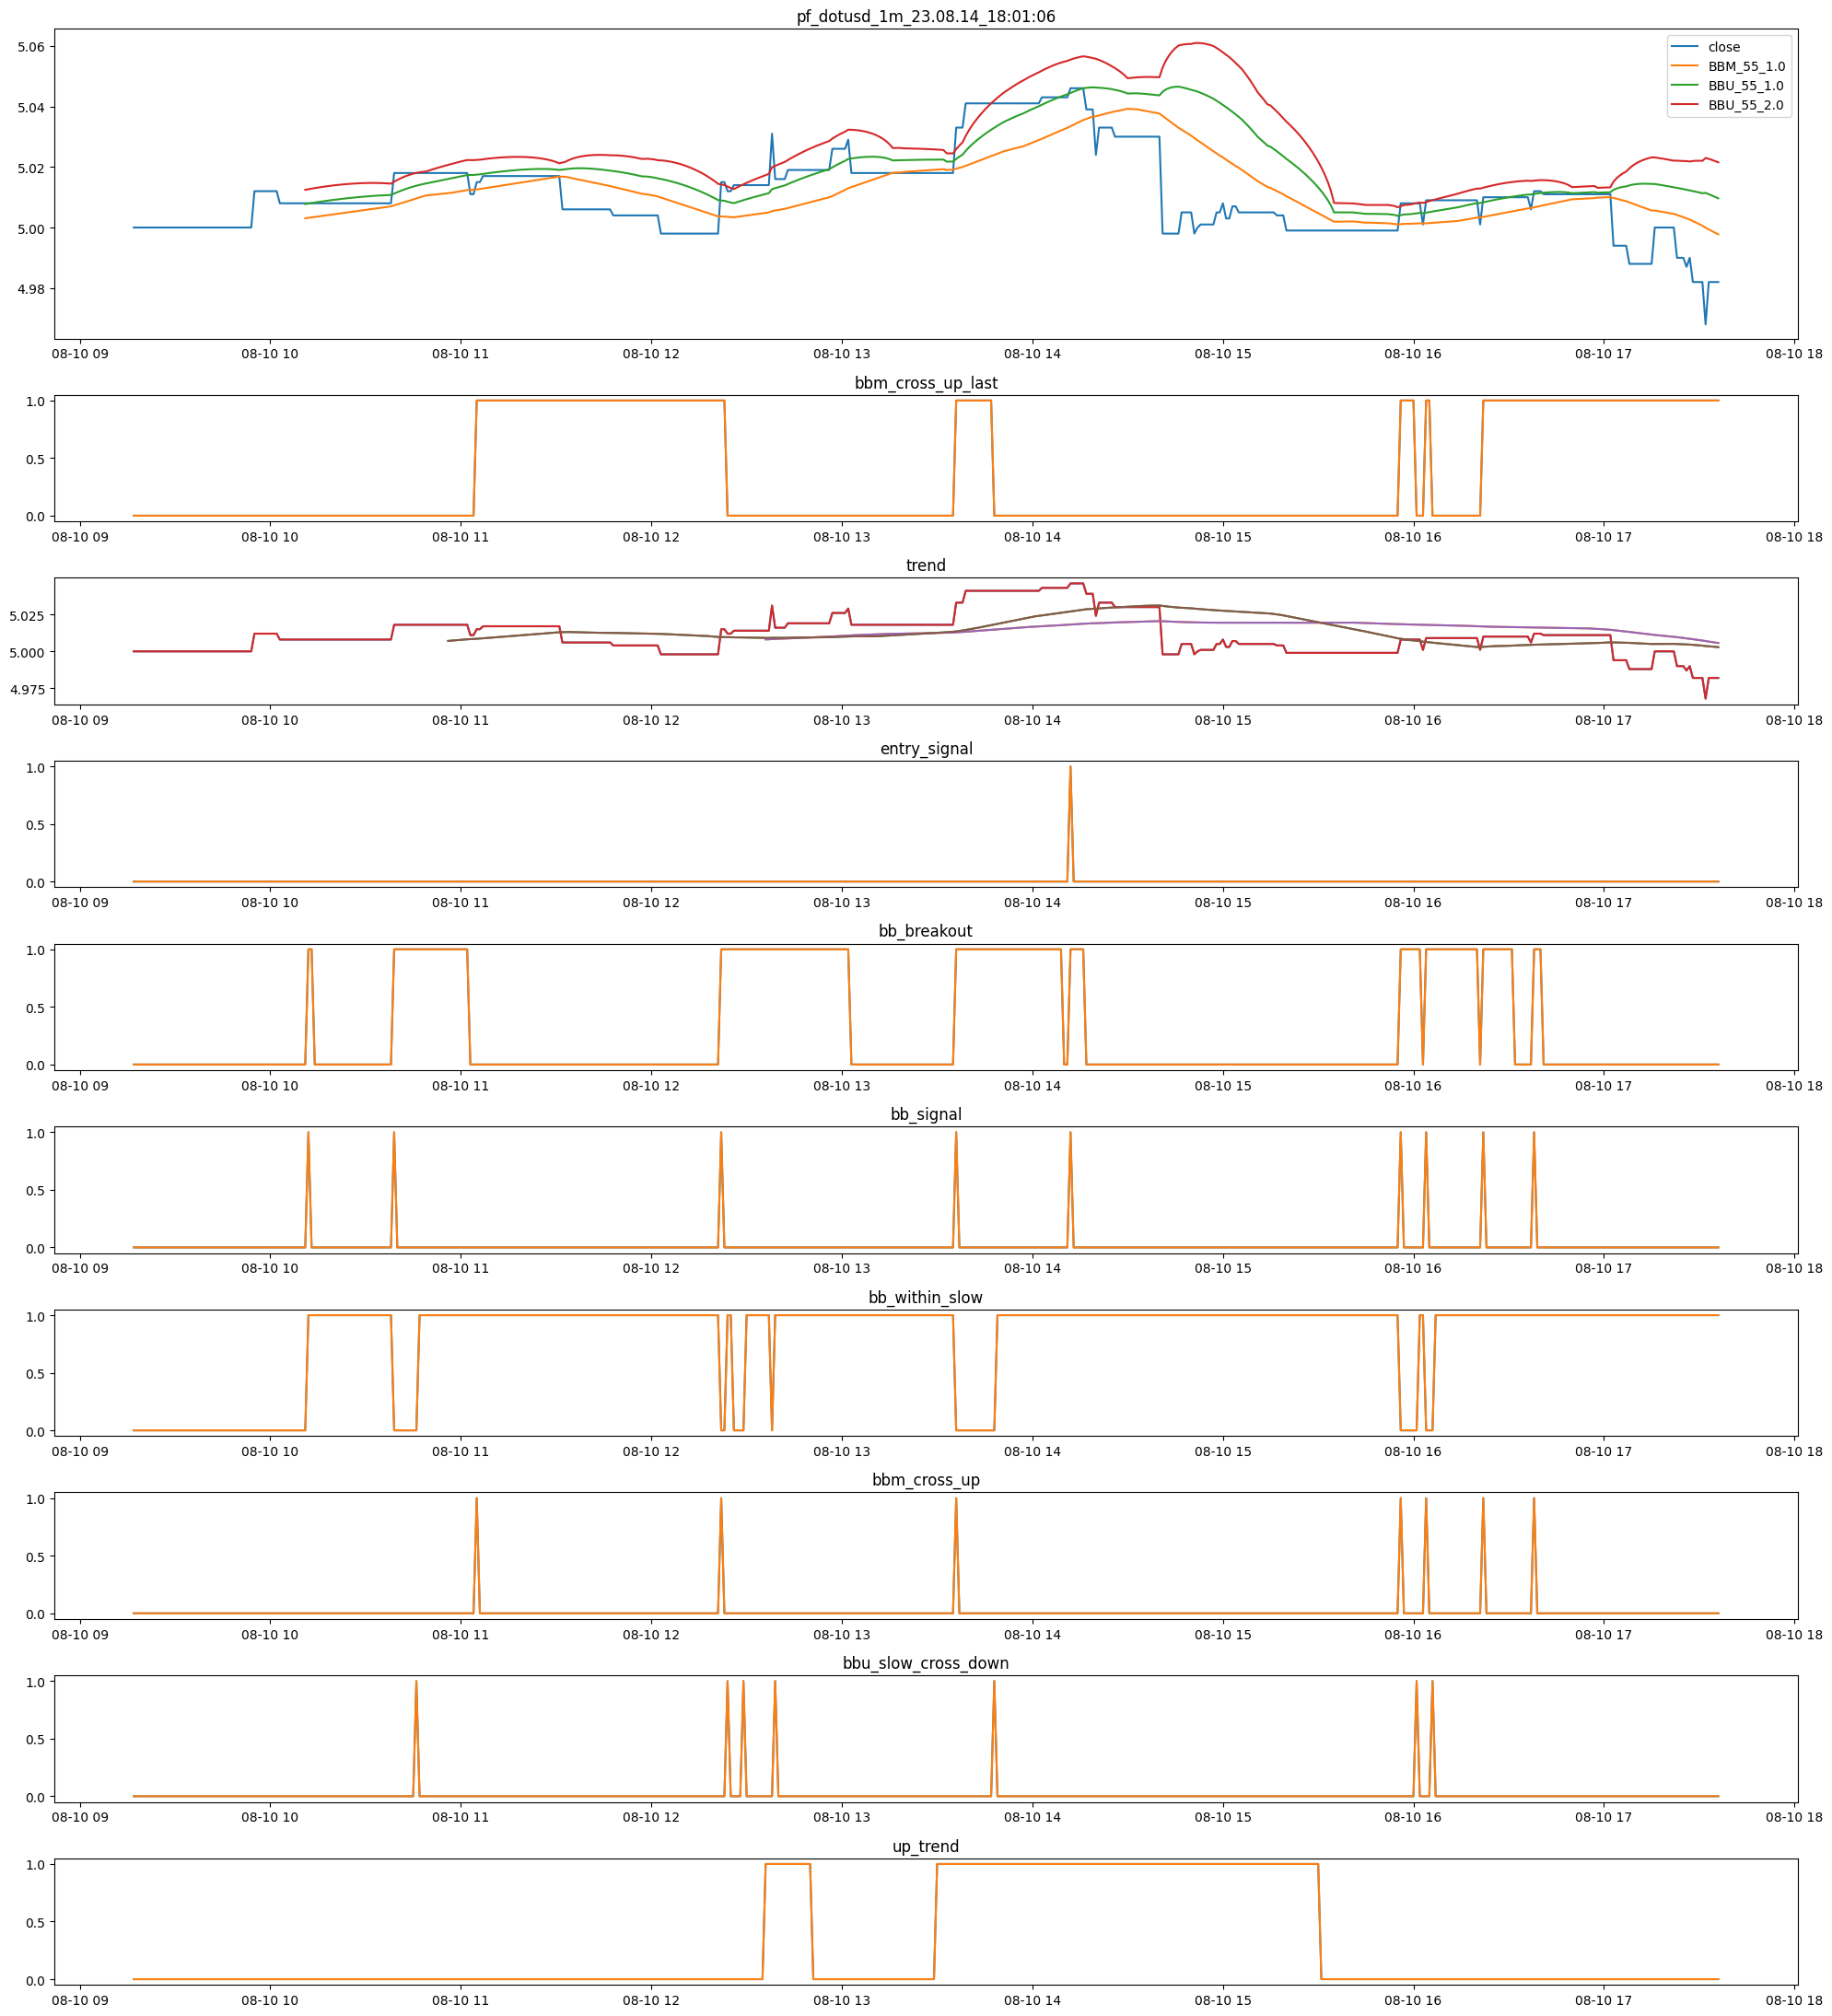

In [81]:

chart_data      = df[['close', bbm, bbu, bbu_slow]]
trend           = ('trend', df[['close', slowMa, fastMa]])
entry_signal    = ('entry_signal', df[['entry_signal']] )
bb_signal       = ('bb_signal', df[['bb_signal']] )
bb_breakout     = ('bb_breakout', df[['bb_breakout']] )
bb_within_slow  = ('bb_within_slow', df[['bb_within_slow']] )
up_trend        = ('up_trend', df[['up_trend']] )
bbm_cross_up            = ('bbm_cross_up', df[['bbm_cross_up']] )
bbu_slow_cross_down     = ('bbu_slow_cross_down', df[['bbu_slow_cross_down']] )
bbm_cross_up_last       = ('bbm_cross_up_last', df[['bbm_cross_up_last']] )

signals         = [bbm_cross_up_last, trend, entry_signal, bb_breakout, bb_signal, bb_within_slow, bbm_cross_up, bbu_slow_cross_down, up_trend]
chart(pair, str(interval), chart_data, signals)


SO

Regla: 
+ Vera fyrir neðan SO threshold (%) ('so_price_deviation') á síðasta kauptilboði ('last_order_price')
+ RSI er að krossa upp yfir threshold ('cross_up_trigger')

In [9]:
df = df_org.copy()
last_order_price = 4.955
position_avg_price = last_order_price

# Settings
so_price_deviation  = 1.
rsi_length          = 14
cross_up_trigger    = 50.

rsi_col_name = f"RSI_{rsi_length}"

strategy = ta.Strategy(
    name="strategy_BBbreakout",
    ta=[ {
        "close":    'close',
        "kind":     'rsi', 
        "length":   rsi_length
    }]
)
df.ta.strategy(strategy)
df['position_avg_price'] = position_avg_price
df['last_order_price'] = last_order_price

df["rsi_cross_up"] = (df[rsi_col_name] > cross_up_trigger) & (df[rsi_col_name].shift() < cross_up_trigger)

soThreshold = last_order_price * (1 - (so_price_deviation / 100) )
df['so_threshold'] = soThreshold

df['RSI_50'] = 50.
df['cross_up_trigger'] = cross_up_trigger
df['so_price_below_threshold'] = df['close'] < df['so_threshold']
df['so_signal'] = (df['so_price_below_threshold'] == True) & (df['rsi_cross_up'] == True)

# df.tail()


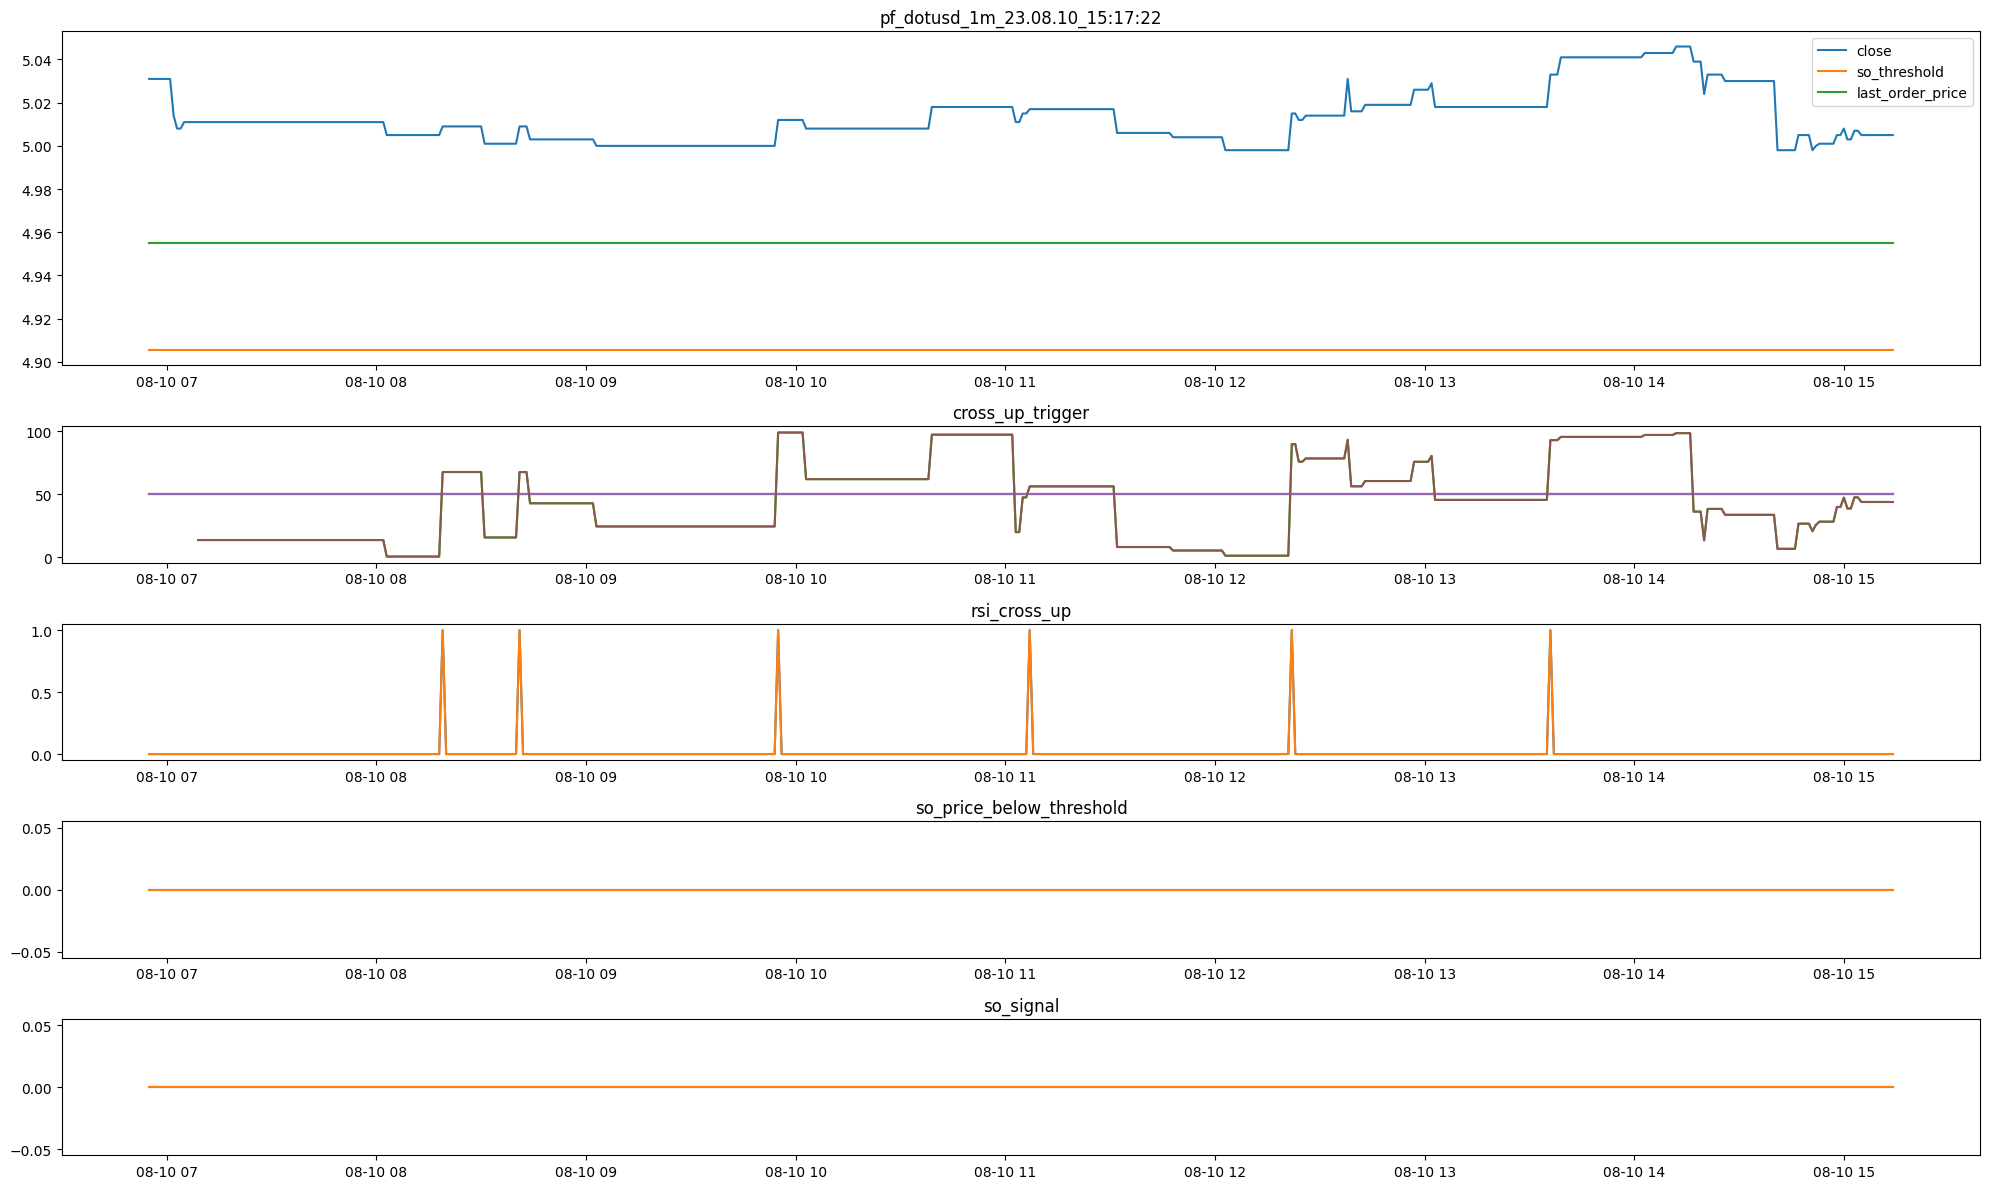

In [10]:
chart_data                  = df[['close', 'so_threshold', 'last_order_price']]
rsi_data                    = ('cross_up_trigger', df[['RSI_50', 'cross_up_trigger', rsi_col_name]])
so_signal                   = ('so_signal', df[['so_signal']])
so_price_below_threshold    = ('so_price_below_threshold', df[['so_price_below_threshold']])
rsi_cross_up_d              = ('rsi_cross_up', df[['rsi_cross_up']])

s = [rsi_data, rsi_cross_up_d, so_price_below_threshold, so_signal]
chart(pair, str(interval), chart_data, s)


TP

Regla: 
+ Þarf að vera ofar en TP target ('take_profit_price')  
+ RSI crossar niður fyrir tiltekið level ('tp_rsi_cross_down_trigger')


In [499]:
df = df_org.copy()

last_order_price = 4.955
position_avg_price = last_order_price

# Settings
target_profit               = 1.
tp_rsi_cross_down_trigger   = 55.
rsi_length                  = 14

rsi_col_name = f"RSI_{rsi_length}"

strategy = ta.Strategy(
    name="strategy_BBbreakout",
    ta=[ {
        "close":    'close',
        "kind":     'rsi', 
        "length":   rsi_length
    }]
)
df.ta.strategy(strategy)


take_profit_price = position_avg_price + (position_avg_price * ((target_profit) / 100))

df['tp_rsi_cross_down_trigger'] = tp_rsi_cross_down_trigger
df['take_profit_price']         = take_profit_price

df["rsi_tp_cross_down"] = (df[rsi_col_name] < tp_rsi_cross_down_trigger) & (df[rsi_col_name].shift() > tp_rsi_cross_down_trigger)
df['above_tp_price']    = df['close'] > df['take_profit_price'].shift()
df['tp_trigger']        = df['rsi_tp_cross_down'] & df['above_tp_price']

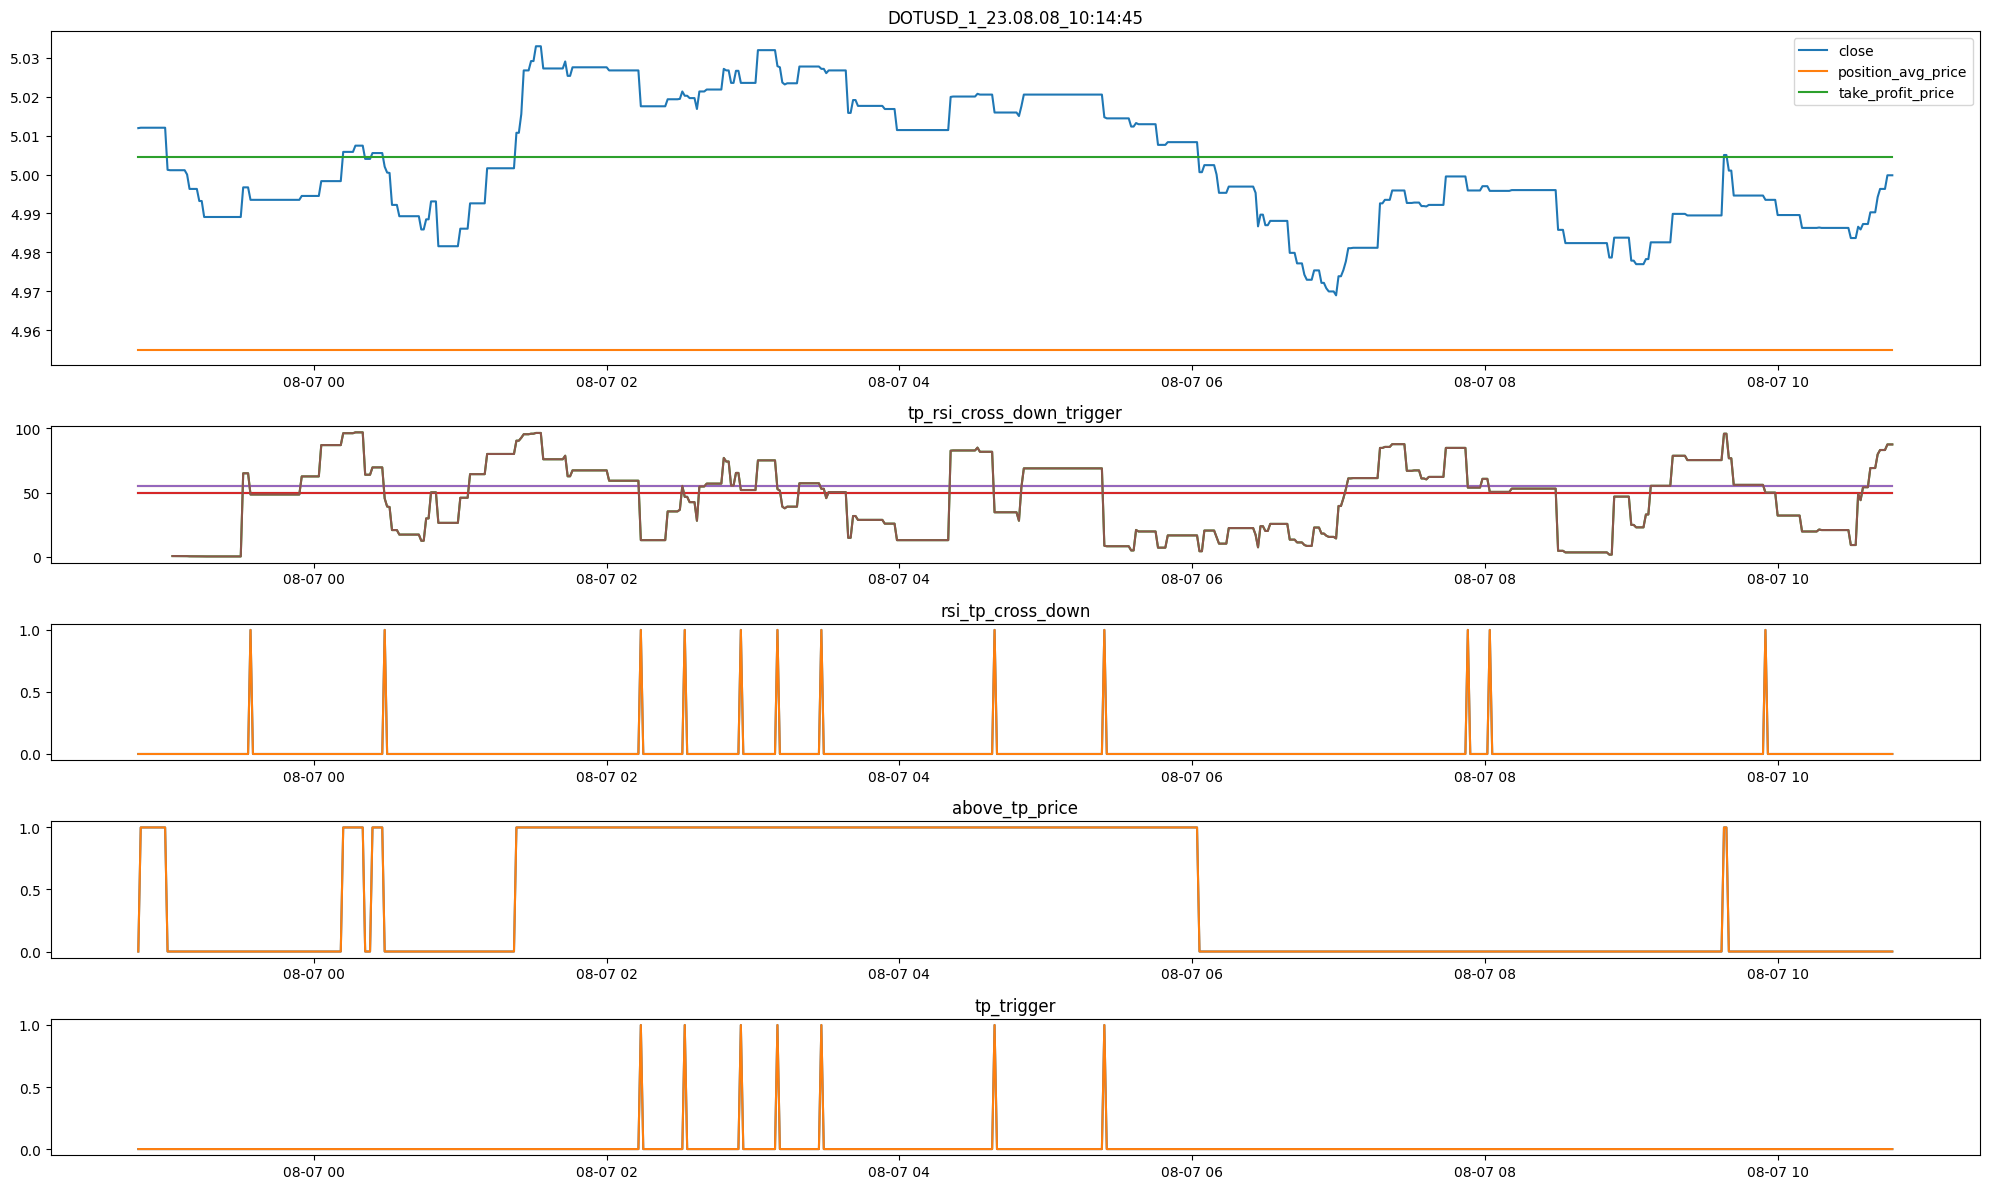

In [500]:
df['RSI_50'] = 50.
df['position_avg_price'] = position_avg_price
df['last_order_price'] = last_order_price

chart_data                  = df[['close', 'position_avg_price', 'take_profit_price']]
tp_rsi_cross_down_trigger   = ('tp_rsi_cross_down_trigger', df[['RSI_50', 'tp_rsi_cross_down_trigger', rsi_col_name]])
tp_trigger                  = ('tp_trigger', df[['tp_trigger']])
rsi_tp_cross_down           = ('rsi_tp_cross_down', df[['rsi_tp_cross_down']])
above_tp_price              = ('above_tp_price', df[['above_tp_price']])
s = [tp_rsi_cross_down_trigger, rsi_tp_cross_down, above_tp_price, tp_trigger]
chart(pair, str(interval), chart_data, s)

In [13]:
df = df.copy()

df.tail()


,open,high,low,close,volume,BBL_55_1.0,BBM_55_1.0,BBU_55_1.0,BBB_55_1.0,BBP_55_1.0,...,BBP_55_2.0,SMA_100,SMA_200,up_trend,ema_cross_up,ema_cross_down,bb_breakout,bb_within_slow,bb_signal,entry_signal
time,,,,,,,,,,,,,,,,,,,,,
2023-08-10 15:10:00,5.005,5.005,5.005,5.005,0.0,5.000882,5.016018,5.031155,0.603520,0.136035,...,0.318018,5.02625,5.019405,True,False,False,False,True,False,False
2023-08-10 15:11:00,5.005,5.005,5.005,5.005,0.0,5.000630,5.015273,5.029916,0.583935,0.149227,...,0.324613,5.02612,5.019410,True,False,False,False,True,False,False
2023-08-10 15:12:00,5.005,5.005,5.005,5.005,0.0,5.000312,5.014655,5.028997,0.572037,0.163437,...,0.331718,5.02599,5.019415,True,False,False,False,True,False,False
2023-08-10 15:13:00,5.005,5.005,5.005,5.005,0.0,5.000027,5.014036,5.028045,0.558793,0.177481,...,0.338741,5.02586,5.019420,True,False,False,False,True,False,False
2023-08-10 15:14:00,5.005,5.005,5.005,5.005,0.0,4.999779,5.013418,5.027057,0.544104,0.191395,...,0.345698,5.02573,5.019425,True,False,False,False,True,False,False


In [196]:
from lucy.infrastructure.repos.position_repository import PositionRepository
from lucy.infrastructure.repos.fills_repository import FillsRepository, Fills
from lucy.infrastructure.repos.bot_repository import BotRepository
from lucy.model.id import Id

In [227]:
pos = PositionRepository().fetch_with_data('EurdvVPVy4')
pos.orders.avg_accumulation_fill_price()

8.043999999999999

In [194]:
print(pos.orders)
print(pos)

Orders:: 2 ['d42bb8e4-41ce-44d3-b4fd-1661d1dd1bc0: entry', 'f1590906-10a9-431f-95b7-e794a96a12a4: close']
Position 76857pUz7E Bot: Dr2uo9ptrb, open: False, 2023-08-16 15:00:11.499614 Profit: -0.09600000000000541 -0.20153671747072557%
 Signal:: strategy: BBbreakout, ticker: pf_atomusd, side: long, signal_type: entry, interval: 1, bar_open_time: 2023-08-16 14:59:00, signal_time: 2023-08-16 14:59:00, close: 7.94, id: 8KGi6qwQ7n, position_id: 76857pUz7E, bot_id: Dr2uo9ptrb 
 Signal:: strategy: BBbreakout, ticker: pf_atomusd, side: long, signal_type: close, interval: 1, bar_open_time: 2023-08-16 15:00:00, signal_time: 2023-08-16 15:00:00, close: 7.939, id: 3iDYoqBgoV, position_id: 76857pUz7E, bot_id: Dr2uo9ptrb 
 Order:: id: d42bb8e4-41ce-44d3-b4fd-1661d1dd1bc0, position_id: 76857pUz7E, bot_id: Dr2uo9ptrb, symbol: pf_atomusd, qty: 6.0, price: 8.018, side: buy, order type: 'entry' type: ioc, filled: 0, limit_price: 8.018, reduce_only: False, order_created_at: 2023-08-16 14:59:54.814000, last

In [269]:
bot = BotRepository().fetch_bot('Dr2uo9ptrb')
print(bot)

Bot atom_1m capital: 200.0, entry size: 50.0 so size: 50.0 max so's 2, No shorts Dr2uo9ptrb
 Position EurdvVPVy4 Bot: Dr2uo9ptrb, CLOSED PnL: 0.000 0.00% 2023-08-15 19:22:19.622804
  Signal:: 'BBbreakout' pf_atomusd LONG ENTRY '1m' close: 8.068 id: J73ibB7kiJ pos: EurdvVPVy4 bot: Dr2uo9ptrb bar_open_time: 2023-08-15 19:22:00 signal_time: 2023-08-15 19:22:00
  Signal:: 'BBbreakout' pf_atomusd LONG ADD_FUNDS '1m' close: 8.021 id: AXDDgjpBXo pos: EurdvVPVy4 bot: Dr2uo9ptrb bar_open_time: 2023-08-15 19:27:00 signal_time: 2023-08-15 19:27:00
  Signal:: 'BBbreakout' pf_atomusd LONG ADD_FUNDS '1m' close: 8.031 id: 6KYgz7E5P3 pos: EurdvVPVy4 bot: Dr2uo9ptrb bar_open_time: 2023-08-15 19:27:00 signal_time: 2023-08-15 19:27:00
  Signal:: 'BBbreakout' pf_atomusd LONG CLOSE '1m' close: 8.042 id: 9aGCUASzwm pos: EurdvVPVy4 bot: Dr2uo9ptrb bar_open_time: 2023-08-15 19:30:00 signal_time: 2023-08-15 19:30:00
  Order:: id: 02f1f480-336c-4c90-a26d-45b7712e0edb, position_id: EurdvVPVy4, bot_id: Dr2uo9ptrb

In [211]:
p = bot.positions[-1]
print(p)

Position GfHjRbY965 Bot: Dr2uo9ptrb, open: False, 2023-08-16 15:39:17.314255 PnL: -0.07179999999999609 -0.15113307709470045%
 Signal:: strategy: BBbreakout, ticker: pf_atomusd, side: long, signal_type: entry, interval: 1, bar_open_time: 2023-08-16 15:38:00, signal_time: 2023-08-16 15:38:00, close: 7.918, id: 6rZf2BCuQ8, position_id: GfHjRbY965, bot_id: Dr2uo9ptrb 
 Signal:: strategy: BBbreakout, ticker: pf_atomusd, side: long, signal_type: close, interval: 1, bar_open_time: 2023-08-16 15:39:00, signal_time: 2023-08-16 15:39:00, close: 7.918, id: CWVVM2e5aH, position_id: GfHjRbY965, bot_id: Dr2uo9ptrb 
 Order:: id: 5b0bddf0-7b03-43e8-965d-fba3cfc1e65d, position_id: GfHjRbY965, bot_id: Dr2uo9ptrb, symbol: pf_atomusd, qty: 6.0, price: 7.996, side: buy, order type: 'entry' type: ioc, filled: 0, limit_price: 7.996, reduce_only: False, order_created_at: 2023-08-16 15:39:00.560000, last_update_timestamp: 2023-08-16 15:39:00.560000, created_at: 2023-08-16 15:39:17.321063
 Order:: id: e422a03a-

In [243]:
from lucy.model.interval import Interval

In [261]:
i = Interval("1m")
print(i)

1m
1m
